### Import Libraries

In [1]:
import glob
import cv2 as cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from skimage.feature import hog 

#### Analyzing Vehicle data

#### Analyzing YCrCb color space Histogram on Vehicle data

#### Analyzing YCrCb color space Histogram on Non Vehicle data

In [2]:
from skimage.feature import hog
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block),transform_sqrt=False, 
                                  visualize=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block),transform_sqrt=False, 
                       visualize=vis, feature_vector=feature_vec)
        return features

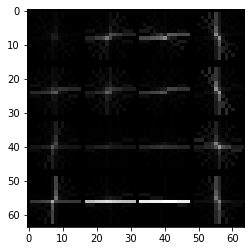

In [3]:
image = cv2.imread('./Data/vehicles/GTI_Far/image0005.png')
feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
x,y = get_hog_features(feature_image[:,:,0], 11, 
                        16, 2, vis=True, feature_vec=True)
plt.imshow(y, cmap='gray')

In [4]:
def image_features(img, color_space='RGB', size=(32, 32)):
            
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256),
                        orient=9,pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True, class_type='S'
                    ):
    # Create a list to append feature vectors to
    features = []
    
    for img in imgs:
        image_orig= cv2.imread(img)
        images=[image_orig]
        image_flipped= cv2.flip(image_orig,1)
        images.append(image_flipped)
#         if class_type=='C': 
#             images.append(cv2.resize(image_orig,(72,72))[0:64,0:64])
#             images.append(cv2.resize(image_flipped,(72,72))[0:64,0:64])
            
        for image in images:
            feature_image=None
            if color_space != 'RGB':
                if color_space == 'HSV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
                elif color_space == 'LUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
                elif color_space == 'HLS':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
                elif color_space == 'YUV':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
                elif color_space == 'YCrCb':
                    feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
            else: feature_image = np.copy(image) 
            image_feature=[]
            if spatial_feat==True:
                image_feature= image_features(feature_image, color_space, spatial_size) 

            histogram_features=[]
            if hist_feat==True:
                histogram_features= color_hist(feature_image, hist_bins, hist_range)

            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
    #         print(hog_features[0])
    #         features.append(hog_features)
            features.append(np.concatenate((image_feature, histogram_features,hog_features)))

       
    return features

#### Loading Data- Vehicle and non vehicle Images

In [5]:
non_vehicles_paths= glob.glob('./Data/non-vehicles/Extras/*.png')
non_vehicles_paths2= glob.glob('./Data/non-vehicles/GTI/*.png')
# moved= glob.glob('./vehicles/moved/*.png')
vehicles_far= glob.glob('./Data/vehicles/GTI_Far/*.png')
vehicles_left= glob.glob('./Data/vehicles/GTI_Left/*.png')
vehicles_middleclose= glob.glob('./Data/vehicles/GTI_MiddleClose/*.png')
vehicles_right= glob.glob('./Data/vehicles/GTI_Right/*.png')
vehicles_KITTI_extracted= glob.glob('./Data/vehicles/KITTI_extracted/*.png')
vehicle_folders=[vehicles_far,vehicles_left,vehicles_middleclose,vehicles_right,vehicles_KITTI_extracted]
non_vehicle_folders=[non_vehicles_paths,non_vehicles_paths2]
vehicles=[]
non_vehicles=[]

for vehicle_folder in vehicle_folders:
    i=0
    for vehicle_path in vehicle_folder:
#         if i%2==0:
       vehicles.append(vehicle_path)
#         i+=1    
for non_vehicle_folder in non_vehicle_folders:
    i=0
    for non_vehicle in non_vehicle_folder:
#         if i%2==0:
        non_vehicles.append(non_vehicle)
#         i+=1

print(len(vehicles), len(non_vehicles))


8792 8968


In [6]:
cars = []
notcars = []
cars=vehicles
notcars=non_vehicles
print(len(notcars)+len(cars))

17760


#### Function to generate Windows

In [7]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5), offset=0):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = (img.shape[0]//2)+offset #(img.shape[0]*2//3)+20
#         print((img.shape[0]//2)-100)
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]

    window_list = []

    
    scales=[1,1.5,2, 2,3]
    ystart=y_start_stop[0]
    for scale in scales:
        over_x= xy_overlap[0]
        over_y= xy_overlap[1]
        width= xy_window[0]*scale
        height= xy_window[1]*scale
        c= y_start_stop[0]
        
        for row in range(2):
            col=0
            endx=0
            image_width= img.shape[1]
            
            while(endx<image_width):
                
                startx = x_start_stop[0]+ col*width*(1-over_x)
                endx = startx + width
                starty = ystart+ row*height*(1-over_y)
                endy = starty + height
                if(endx-startx==endy-starty and endx-startx!=0):
#                     print(endx-startx, endy-starty)
                    window_list.append(((int(startx), int(starty)), (int(endx), int(endy)), width/64.0))
                col+=1
#         y_start_stop[0]-=5    
    return window_list

#### Function to generate features of single image

In [8]:
def single_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
#         print(feature_image)
        
        spatial_features = image_features(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
       
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)


#### Searching each window for vehicle features

In [9]:
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    last_ratio=0
    i=0
    imageCopy= np.copy(img)
    for window in windows:
#         print(window)
        if(last_ratio!= window[2]):
            last_ratio=window[2]
#             plt.imshow(imageCopy)
#             print((img.shape[0]//last_ratio, img.shape[1]//last_ratio))
            imageCopy= cv2.resize(img, (int(img.shape[1]/last_ratio), int(img.shape[0]/last_ratio))) 
        #3) Extract the test window from original image
#         print(window[2])
#         test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
#         print(img.shape)
        test_img = imageCopy[int(window[0][1]/last_ratio):int(window[1][1]/last_ratio), int(window[0][0]/last_ratio):int(window[1][0]/last_ratio)]
        if test_img.shape[0]==test_img.shape[1] and test_img.shape[0]!=0:
            
#             plt.imshow(test_img)
#             if i==2:
#                 break
#             i+=1
#             print(test_img.shape, last_ratio)
        #4) Extract features for that window using single_img_features()
            features = single_img_features(test_img, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)
            #5) Scale extracted features to be fed to classifier
    #         print(features)
            test_features = scaler.transform(np.array(features).reshape(1, -1))
    #         print(test_features)
            #6) Predict using your classifier
            prediction = clf.predict (test_features)

    #         #7) If positive (prediction == 1) then save the window
            if prediction == 1:
                window1=(window[0],window[1],prediction)
                on_windows.append(window1)

        #     prob = clf.decision_function(test_features)
        #     window1=(window[0],window[1],prob)
        #     if(prob>1):
        #         on_windows.append(window1)
    #8) Return windows for positive detections
    return on_windows

#### drawing boxes over predicted windows

In [10]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
#         print(bbox[2])
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
        point=(bbox[0][0],bbox[0][1]-20)
        text= str(bbox[2])
        cv2.putText(imcopy,text,point, cv2.FONT_HERSHEY_SIMPLEX, 0.4,(255,0,0),1,cv2.LINE_AA)
    # Return the image copy with boxes drawn
    return imcopy

#### Setting Hyper parameters and extracting car and non car features

In [11]:
%%time


sample_size = 500
# cars = cars[0:sample_size]
# notcars = notcars[0:sample_size]

print(len(notcars)+len(cars))
### TODO: Tweak these parameters and see how the results change.
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 12  # HOG orientations
pix_per_cell = 16 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (16, 16) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [None, None] # Min and max in y to search in slide_window()

print('extraction started') 
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, class_type='C'
                               )


notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat, class_type='N'
                                  )

print('extraction ended') 

# print(notcar_features.shape, car_features.shape)
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets





17760
extraction started
extraction ended
Wall time: 4min 17s


#### Normalization

In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 

Using: 12 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 2160


#### Training and Testing 

In [13]:
%%time
from sklearn.svm import LinearSVC

print('training started') 
clf = LinearSVC()
LinearSVC( 
            C=1000.0  
    #loss='hinge'
          #, gamma='auto'
          #, kernel='linear'
         )

clf.fit(X_train, y_train)
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))



training started
Test Accuracy of SVC =  0.9942
Wall time: 6.35 s


c:\Users\lenovo\anaconda3\lib\site-packages\sklearn\svm\_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


#### additional functions

In [14]:
from scipy.ndimage.measurements import label
heat = np.zeros_like(image[:,:,0]).astype(np.float)

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    coord=[]
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        point=(np.min(nonzerox), np.min(nonzeroy)-20)
        text= 'Car '+ str(car_number)
#         cv2.putText(img,text,point, cv2.FONT_HERSHEY_SIMPLEX, 0.5,(0,255,0),2,cv2.LINE_AA)
        # Draw the box on the image
        aspect_ratio= float(bbox[1][0]-bbox[0][0])/(bbox[1][1]-bbox[0][1])
        if(aspect_ratio>=0.8 ):
            
            coord.append((bbox[0], bbox[1]))
    # Return the image
    return img, coord

def draw_objects(coords, draw_img):
    out_image = np.zeros((720,1280,3), dtype=np.uint8)
    index=1
    out_image[0:720,0:1280,:] = cv2.resize(draw_img,(1280,720)) 
    offset_left=30
    offset_start=30
    mid_gap=40
    
    for coord in coords:
        if(index<4):
            x_start= coord[0][0]
            y_start= coord[0][1]
            x_end= coord[1][0]
            y_end= coord[1][1]
            if x_end-x_start>70 and y_end-y_start>50:
                aspect_ratio= float(x_end-x_start)/(y_end-y_start)

                detected_image = np.zeros((150,220,3), dtype=np.uint8)
                if(aspect_ratio>=0.8 and aspect_ratio<=4):
                    detected_image= cv2.resize(draw_img[y_start+5:max(y_end-5,y_start+80),x_start+5:max(x_end-5,x_start+115)],(220,150))
                    cv2.rectangle(out_image,(offset_left-2,offset_start-2),(offset_left+222,offset_start+152 ), (255,255,255), 3)
                else:
                    cv2.putText(detected_image,'Bad Quality ',(50,80), cv2.FONT_HERSHEY_SIMPLEX, 0.7,(255,0,0),2,cv2.LINE_AA)
                    cv2.rectangle(out_image,(offset_left-2,offset_start-2),(offset_left+222,offset_start+152 ), (255,0,0), 3)
                cv2.rectangle(out_image, coord[0], coord[1], (226,203,255), 6)
                out_image[offset_start:offset_start+150,offset_left:offset_left+220,:] = cv2.resize(detected_image,(220,150))
                cv2.putText(out_image,'Car '+str(index)+' detected',(offset_left,offset_start-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6,(255,255,255),2,cv2.LINE_AA)
                offset_start+=150+mid_gap
        index+=1
    return out_image

C:\Users\lenovo\AppData\Local\Temp/ipykernel_15328/2202427619.py:2: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  heat = np.zeros_like(image[:,:,0]).astype(np.float)


#### Analyzing test images

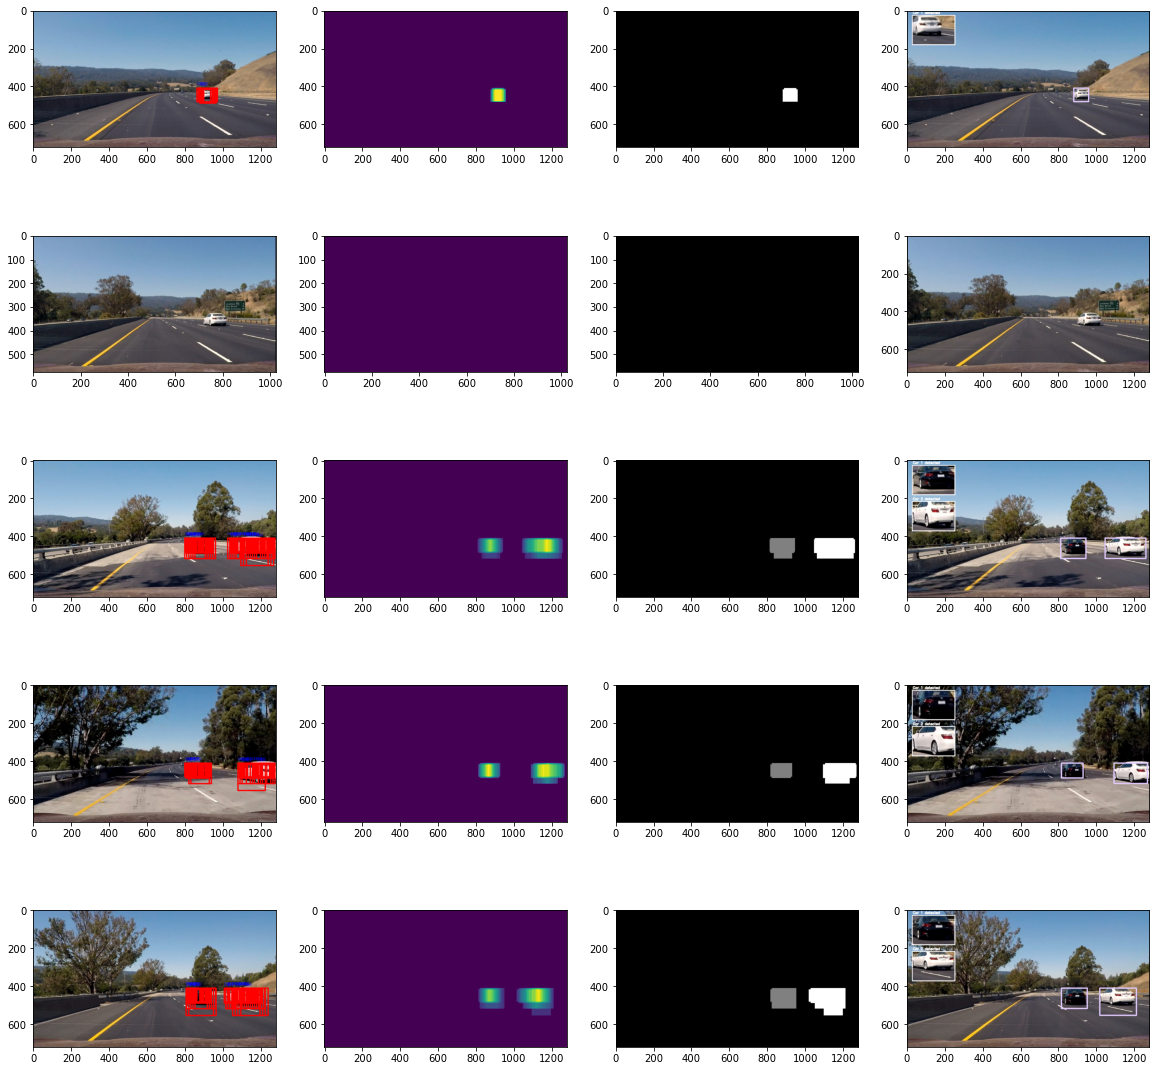

In [196]:

image=None

images= glob.glob('./test_images/*.jpg')
f,axes= plt.subplots(5,4, figsize=(20,20))
i=0
# for i in range(0,6):
for img in images[28:33]:
    
    image = cv2.imread(img)

    draw_image = np.copy(image)
    windows = slide_window(draw_image, x_start_stop=[None, None], y_start_stop=[None, None], 
                        xy_window=(72, 72), xy_overlap=(0.9,0.9), offset=50)
    
#     print(len(windows))
    hot_windows = search_windows(image, windows, clf, X_scaler, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)                       

    window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    
    window_img= cv2.cvtColor(window_img, cv2.COLOR_BGR2RGB)
    axes[i,0].imshow(window_img)
    heat = np.zeros_like(image[:,:,0]).astype(np.float)
    heat = add_heat(heat,hot_windows)
    
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,3) 
    heatmap = np.clip(heat, 0, 255)
    axes[i,1].imshow(heatmap)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img,coord = draw_labeled_bboxes(np.copy(image), labels)
    axes[i,2].imshow(labels[0], cmap='gray')
    draw_img= draw_objects(coord, cv2.cvtColor(draw_img,cv2.COLOR_BGR2RGB))
    axes[i,3].imshow(draw_img)
    i+=1
# print(windows)

In [178]:
prev_heat=[]

def avg_heat(heat, span):
    global prev_heat
    
    if(len(prev_heat)>span):
        prev_heat.pop(0)
    prev_heat.append(heat)
    return np.mean(prev_heat, axis=0)

prev_windows_left=[]
prev_windows_right=[]
def averaging(curr_windows, span, window_side):
    
    global prev_windows_left
    global prev_windows_right
    result=[]
    if window_side=='R':
        no_of_window_slots=len(prev_windows_right)
        if(no_of_window_slots>span):
            prev_windows_right.pop(0)
        prev_windows_right.append(curr_windows)
        
        for windows in prev_windows_right:

            for window in windows:
    #             print(windows)
                result.append(window)
    else:   
        no_of_window_slots=len(prev_windows_left)
        if(no_of_window_slots>span):
            prev_windows_left.pop(0)
        prev_windows_left.append(curr_windows)
        
        for windows in prev_windows_left:

            for window in windows:
    #             print(windows)
                result.append(window)
        
    return result,no_of_window_slots
    
  

#### PipeLine

In [179]:
prev_windows_left=[]
prev_windows_right=[]
prev_heat=[]
windows_final = slide_window(image, x_start_stop=[600, None], y_start_stop=[None, None], 
                       xy_window=(72, 72), xy_overlap=(0.9,0.9), offset=40)

# print('=========')
last_frame=None
frame_no=0
last_left=None
last_right=None
def Object_pipeline(img):
    draw_image = np.copy(img)
#     draw_image= cv2.cvtColor(draw_image, cv2.COLOR_BGR2RGB)
    global windows_final
    global clf
    global X_scaler
    global color_space
    global spatial_size
    global hist_bins
    global orient
    global pix_per_cell
    global cell_per_block
    global hog_channel
    global spatial_feat 
    global hist_feat 
    global hog_feat 
    global frame_no
    global last_frame
    global last_left
    global last_right
    global prev_heat
   
    result=None
    if frame_no%2!=0 and last_frame is not None:
        result= last_frame
#         _, _= averaging(last_left, 2,'L')
#         _, _= averaging(last_right, 10,'R')
    else:

        hot_windows = search_windows(img, windows_final, clf, X_scaler, color_space=color_space, 
                                spatial_size=spatial_size, hist_bins=hist_bins, 
                                orient=orient, pix_per_cell=pix_per_cell, 
                                cell_per_block=cell_per_block, 
                                hog_channel=hog_channel, spatial_feat=spatial_feat, 
                                hist_feat=hist_feat, hog_feat=hog_feat)                       
    #         window_img = draw_boxes(draw_image, hot_windows, color=(0, 255, 0), thick=6) 

    #     #     average_windows= averaging(hot_windows)
    #         left_windows=[]
    #         right_windows=[]
    #         for windows in hot_windows:
    #             if(windows[1][0]<img.shape[1]//2 +230): # left windows
    #                 left_windows.append(windows)
    #             else: # right windows
    #                 right_windows.append(windows)
    #         last_left= left_windows
    #         last_right= right_windows
    #         left_windows, threshold_left= averaging(left_windows, 2,'L')
    # #         print(threshold_left)
        
    #         right_windows, threshold_right= averaging(right_windows, 15, 'R')
        
    #         heat_left = np.zeros_like(img[:,:,0]).astype(np.float)
    #         heat_left = add_heat(heat_left,left_windows)
    # #         print(threshold_left, len(left_windows))
    #         heat_left = apply_threshold(heat_left,3)
        
    #         heat_right = np.zeros_like(img[:,:,0]).astype(np.float)
    #         heat_right = add_heat(heat_right,right_windows)
    #         heat_right = apply_threshold(heat_right,int(len(right_windows)))
        
    #         heat= np.zeros_like(img[:,:,0]).astype(np.float)
    #         heat= np.dstack((heat_left,heat_right,heat))[:,:,1]
    # #         plt.imshow(heat)
        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        heat = add_heat(heat,hot_windows)
    #         print('curr',np.max(heat))
        heat = avg_heat(heat, 20)
    #         print('Avg',np.max(heat))
        heat = apply_threshold(heat,max(np.max(heat)//2-15 ,2))
    #         print('curr',np.max(heat))
        heatmap = np.clip(heat, 0, 255)
        labels = label(heatmap)
        draw_img, coord = draw_labeled_bboxes(np.copy(img), labels)
        
        draw_img= draw_objects(coord, draw_img)
        last_frame=draw_img
        result= draw_img
    frame_no+=1
#     print(windows_final)
    return result
# image = cv2.imread('./frames/image_75.jpg')
# img= Object_pipeline(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
# plt.imshow(img)
# print(len(windows))

In [180]:
#code to extract frames from video

# import cv2
# import math

# videoFile = "project_video_output8.mp4"
# imagesFolder = "frames"
# cap = cv2.VideoCapture(videoFile)
# frameRate = cap.get(3) #frame rate
# while(cap.isOpened()):
#     frameId = cap.get(1) #current frame number
#     ret, frame = cap.read()
#     if (ret != True):
#         break
# #     if (frameId % math.floor(frameRate) == 0):
#     filename = imagesFolder + "/image_" +  str(int(frameId)) + ".jpg"
#     cv2.imwrite(filename, frame)
# cap.release()
# print("Done!") 

#### Video Processing

In [197]:
prev_windows_left=[]
prev_windows_right=[]
prev_heat=[]
frame_no=0
last_frame=None
import moviepy
from moviepy.editor import VideoFileClip

video_output1 = 'project_video_output8.mp4'
video_input1 = VideoFileClip('project_video_modified3.mp4')#.subclip(40,44)
processed_video = video_input1.fl_image(Object_pipeline)
%time processed_video.write_videofile(video_output1, audio=False)
video_input1.reader.close()
video_input1.audio.reader.close_proc()

Moviepy - Building video project_video_output8.mp4.
Moviepy - Writing video project_video_output8.mp4



Moviepy - Done !
Moviepy - video ready project_video_output8.mp4
Wall time: 4min 52s
